# Evaluating The Yelp Dataset
## Team:
Kowoon Jeong, Taylor Prince, Drew Suarez, Kaera Mishenkov Mitchen, Allison Chen

## Introduction:
A business’ Yelp page provides an initial impression for potential customers searching for a great quality service/meal/experience. When people go out to eat or are looking for any type of service they often reference the yelp page of that business. Having a higher rating (4-5 stars) is important to set a business apart from its many competitors; if you make a search for “Chinese takeout nearby”, along with the most relevant options, the restaurants with the highest ratings and most impressions will be higher in search results. Analyzing what attributes of a restaurant page on Yelp could lead to higher ratings can help business owners make improvements and provide a better impression for potential customers.  

We are trying to understand what attributes affect the ratings of businesses on Yelp.
Specifically, we will be examining overall qualities and services of a restaurant that affect the ratings of the business. We will be focusing on the takeout, delivery, credit card as a form of payment, wifi, alcohol options, price range per person, and attire attributes of a restaurant business, which we believe will be attributes that affect Yelp ratings.

***

## Importing Packages & Setting Up Attributes Column

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json

from statsmodels import stats
import scipy as sp
import scipy.stats as st
import scipy.stats.distributions as dist
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn import metrics

business = pd.read_json("yelp_academic_dataset_business.json", lines = True)
attr = pd.json_normalize(business['attributes'])
business = business.join(attr)

## Relevant Variables:
- **Stars:** 1-5. Star rating given to a business, 5 is highest/best. 
- **RestaurantsTakeOut:** Excluding NA/None values, True or False. 
    - True if restaurant has takeout option, False if not.
- **RestaurantsDelivery:** Excluding NA/None values; True or False. 
    - True if restaurant has delivery option, False if not.
- **WiFi:** After cleaning; free, no, and paid. 
    - free if business has WiFi and it is free
    - paid if business has WiFi and requires payment for access
    - no if business does not have WiFi.
- **Alcohol:** After cleaning; none, full_bar, beer_and_wine. 
    - full_bar if restaurant has a bar serving liquor
    - beer_and_wine if there is an option to order beer or wine but no full bar at the establishment
    - none if the business does not serve alcohol.
- **GoodForKids:** Excluding NA/None values; True or False. 
    - True if the business is considered to be a family/kid-friendly establishment, False if not.
- **BusinessAcceptsCreditCards:** Excluding NA/None values; True or False. 
    - True if the business accepts credit cards as a form of payment, False if not.
- **RestaurantsPriceRange2:** Excluding NA/None values; 1-4. Represents the dollar sign price range from &#36; to &#36;&#36;&#36;&#36;, where each &#36; sign indicates the approximate cost to eat per person. 
    - 1 represents &#36;, where the cost per person is under &#36;10. 
    - 2 represents &#36;&#36;  with a per-person cost of &#36;11-30. 
    - 3 represents &#36;&#36;&#36;  with a per-person cost of &#36;31-60. 
    - 4 represents &#36;&#36;&#36;&#36;, the most expensive restaurants where the per-person cost is &#36;61+.
- **RestaurantsAttire:**: After cleaning; casual, dressy, and formal.
    - casual appears to indicate restaurants where everyday attire is most appropriate.
    - dressy appears to indicate restaurants that are nicer than the average chain restaurant and more put-together attire is most appropriate; ie. more formal than a t-shirt and jeans or workout clothes but less formal than a full suit or gown.
    - formal appears to indicate restaurants that have stricter dress codes and expect nicer attire as some upscale restaurants do; think dresses and suits.

## General Data Cleaning:

In [2]:
# limit scope to restaurant categories
restaurant = business[business['categories'].str.contains('Restaurant', na=False)]

# Calculate the percentage of null values for each attribute key
attrl=pd.DataFrame(list(restaurant['attributes'].dropna().values)) 
null_percentages = (100*attrl.isnull().sum()/len(attrl)).to_frame('null_pct').sort_values(by='null_pct')
print(null_percentages.loc[['RestaurantsTakeOut', 'RestaurantsDelivery', 'BusinessAcceptsCreditCards',
                           'RestaurantsPriceRange2', 'Alcohol', 'WiFi']])

                             null_pct
RestaurantsTakeOut           5.806265
RestaurantsDelivery          7.853828
BusinessAcceptsCreditCards  11.885151
RestaurantsPriceRange2      13.934648
Alcohol                     22.699149
WiFi                        27.012761


## EDA and General Visualizations for Restaurant Subset:

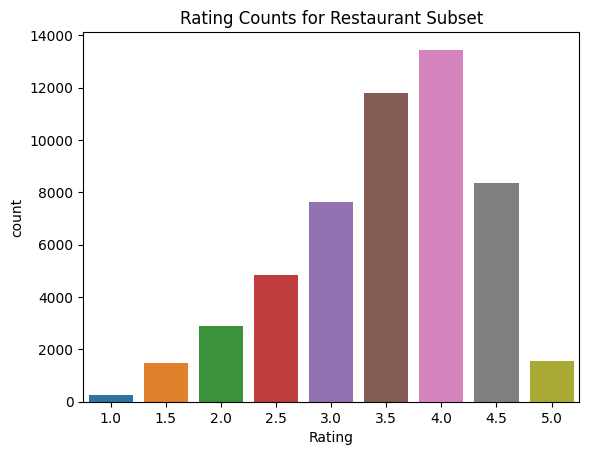

In [3]:
sns.countplot(data = restaurant, x = 'stars')
plt.xlabel("Rating")
plt.title("Rating Counts for Restaurant Subset")
plt.show()

count    52286.000000
mean         3.515234
std          0.829585
min          1.000000
25%          3.000000
50%          3.500000
75%          4.000000
max          5.000000
Name: stars, dtype: float64

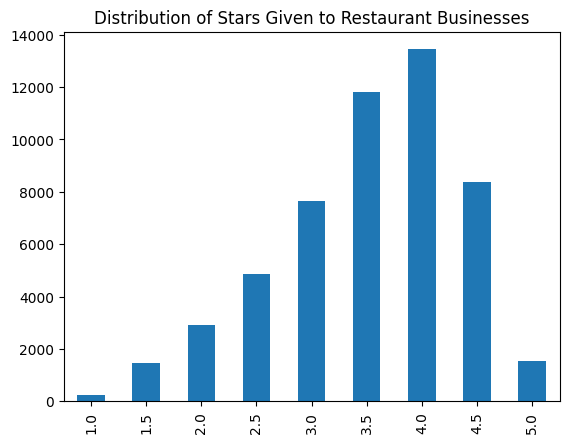

In [4]:
restaurant['stars'].value_counts().sort_index().plot(kind = 'bar', title = 'Distribution of Stars Given to Restaurant Businesses')
restaurant['stars'].describe()

***
## Delivery and Takeout Attribute:
### Hypothesis:
We expect that having a takeout and delivery option would be associated with a higher star rating on Yelp, both when considered individually and in combination with each other.
### Data Cleaning:

In [5]:
# dropping NA values in relevant categories; only including row entries (businesses) that list their takeout and delivery status
deltake = restaurant.dropna(subset=['RestaurantsTakeOut'])
deltake = deltake.dropna(subset=['RestaurantsDelivery'])
# removing "None" listings
deltake = deltake.loc[deltake['RestaurantsTakeOut'] != "None"]
deltake = deltake.loc[deltake['RestaurantsDelivery'] != "None"]

### Basic Stats and Graphs:

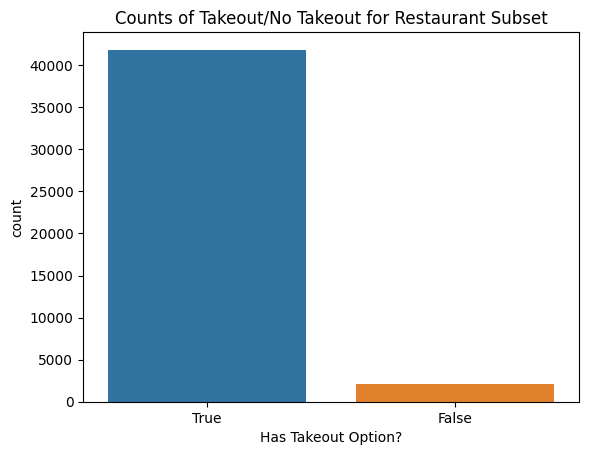

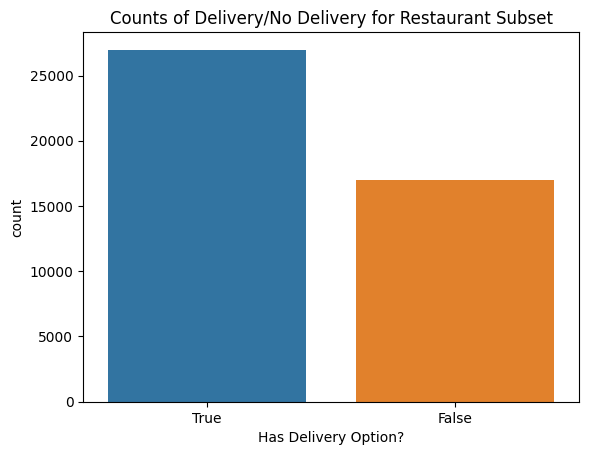

In [6]:
sns.countplot(data = deltake, x = 'RestaurantsTakeOut', order= ['True', 'False'])
plt.xlabel("Has Takeout Option?")
plt.title("Counts of Takeout/No Takeout for Restaurant Subset")
plt.show()
sns.countplot(data = deltake, x = 'RestaurantsDelivery', order= ['True', 'False'])
plt.xlabel("Has Delivery Option?")
plt.title("Counts of Delivery/No Delivery for Restaurant Subset")
plt.show()

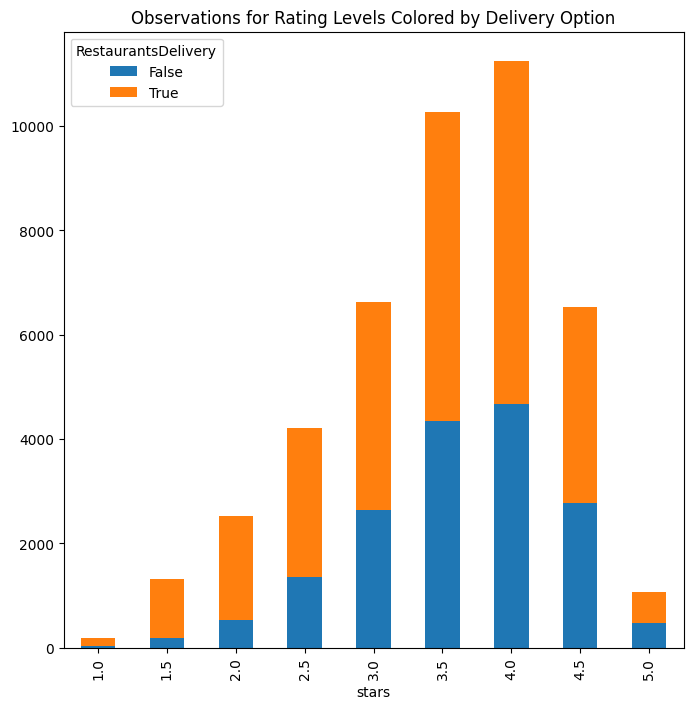

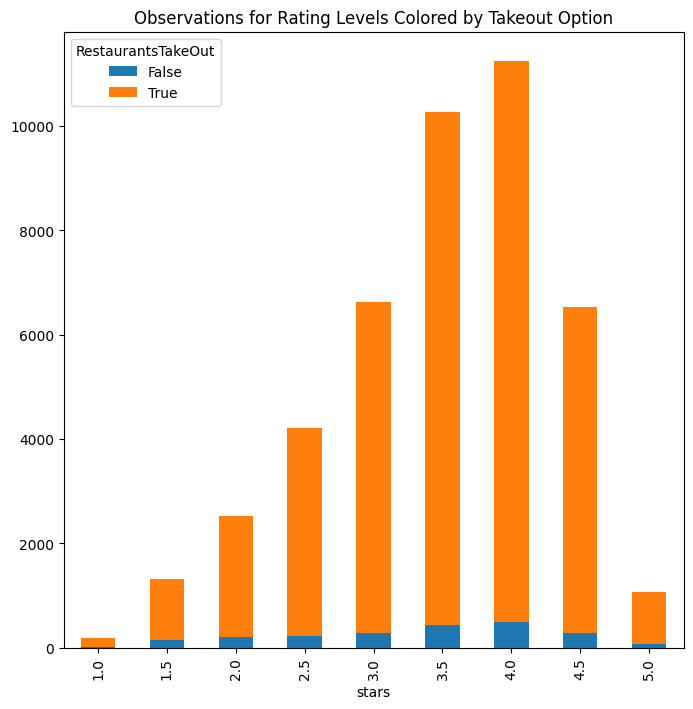

In [7]:
pd.crosstab(index=deltake["stars"], 
                          columns=deltake["RestaurantsDelivery"]).plot(kind="bar", 
                 figsize=(8,8),
                 stacked=True)
plt.title("Observations for Rating Levels Colored by Delivery Option")
plt.show()

pd.crosstab(index=deltake["stars"], 
                          columns=deltake["RestaurantsTakeOut"]).plot(kind="bar", 
                 figsize=(8,8),
                 stacked=True)
plt.title("Observations for Rating Levels Colored by Takeout Option")
plt.show()

In [8]:
print('Means:\nHas Takeout:', deltake[deltake['RestaurantsTakeOut'] == "True"]['stars'].mean())
print('No Takeout:', deltake[deltake['RestaurantsTakeOut'] == "False"]['stars'].mean())
print('Has Delivery:', deltake[deltake['RestaurantsDelivery'] == "True"]['stars'].mean())
print('No Delivery:', deltake[deltake['RestaurantsDelivery'] == "False"]['stars'].mean())

Means:
Has Takeout: 3.493821406376978
No Takeout: 3.3081906524757057
Has Delivery: 3.405419431367461
No Delivery: 3.610357184819645


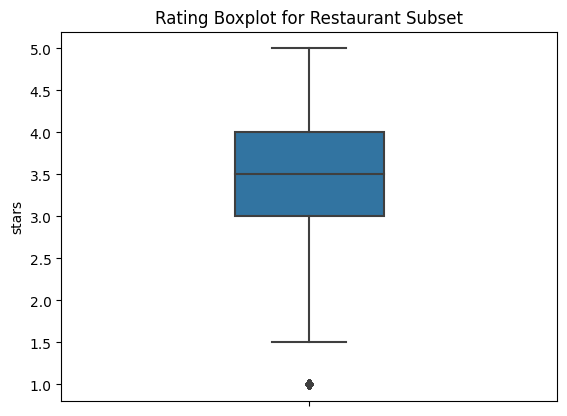

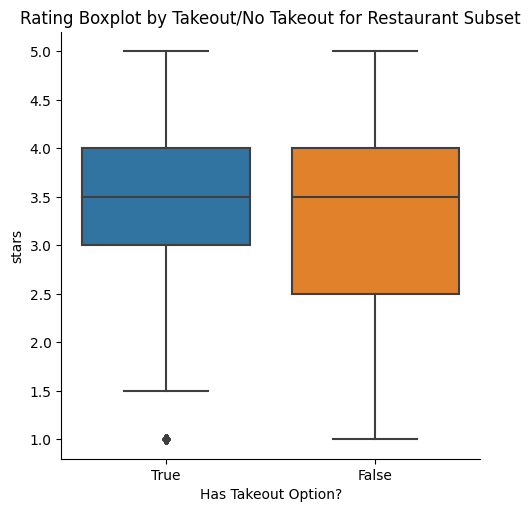

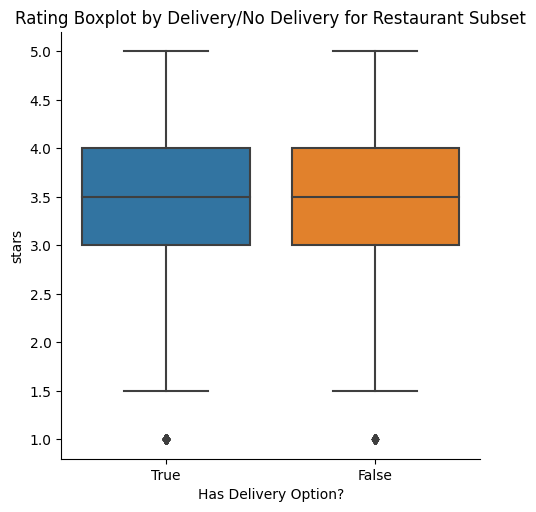

In [9]:
sns.boxplot(data=deltake, y="stars", width = 0.3)
plt.title("Rating Boxplot for Restaurant Subset")
plt.show()
sns.catplot(data=deltake, x="RestaurantsTakeOut", y="stars", kind="box", order= ['True', 'False'])
plt.xlabel("Has Takeout Option?")
plt.title("Rating Boxplot by Takeout/No Takeout for Restaurant Subset")
plt.show()
sns.catplot(data=deltake, x="RestaurantsDelivery", y="stars", kind="box", order= ['True', 'False'])
plt.xlabel("Has Delivery Option?")
plt.title("Rating Boxplot by Delivery/No Delivery for Restaurant Subset")
plt.show()

### Statistical Analysis:

3.493821406376978
3.3081906524757057


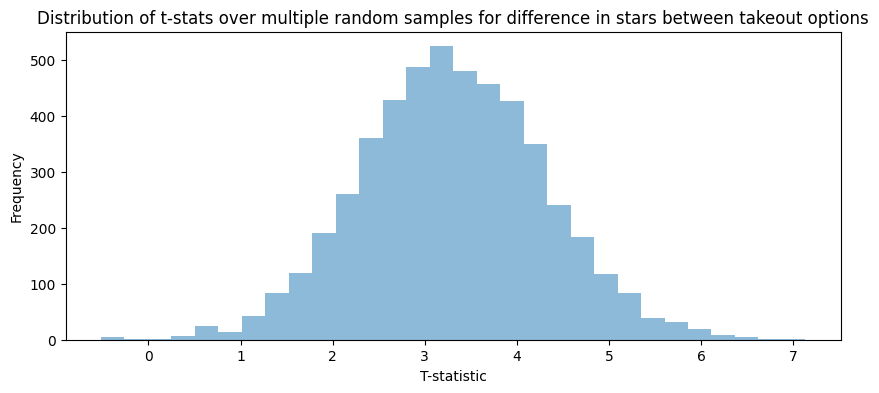

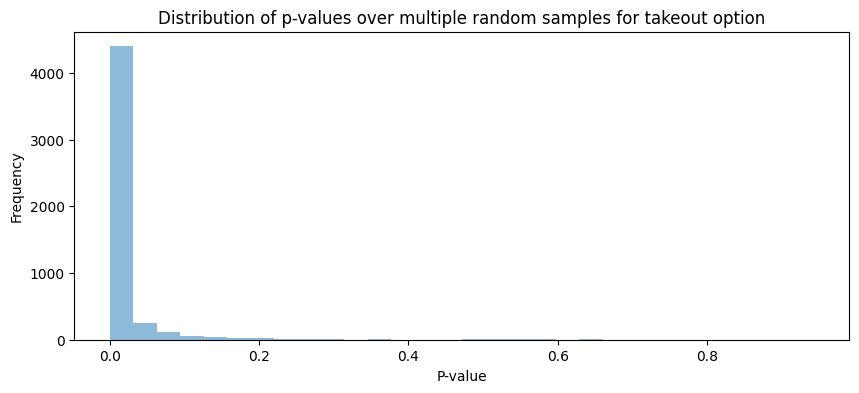

In [10]:
# Evaluating the relationship between rating and takeout option
yesto = deltake[deltake['RestaurantsTakeOut'] == "True"]
noto = deltake[deltake['RestaurantsTakeOut'] == "False"]
print(yesto['stars'].mean())
print(noto['stars'].mean())
stats.weightstats.ttest_ind(yesto['stars'], noto['stars'])

n_iterations = 5000
sample_size = 500
t_stats = np.zeros(n_iterations)
p_values = np.zeros(n_iterations)
df = np.zeros(n_iterations)
for i in range(n_iterations):
    sample1 = np.random.choice(yesto['stars'], sample_size, replace=True )
    sample2 = np.random.choice(noto['stars'], sample_size, replace=True)
    t_stat, p_value, df = stats.weightstats.ttest_ind(
    sample1, sample2, usevar='unequal')
    t_stats[i] = t_stat
    p_values[i] = p_value
plt.figure(figsize=(10,4))
plt.hist(t_stats, bins=30, alpha=0.5)
plt.xlabel('T-statistic')
plt.ylabel('Frequency')
plt.title('Distribution of t-stats over multiple random samples for difference in stars between takeout options')
plt.show()

plt.figure(figsize=(10,4))
plt.hist(p_values, bins=30, alpha=0.5)
plt.xlabel('P-value')
plt.ylabel('Frequency')
plt.title('Distribution of p-values over multiple random samples for takeout option')
plt.show()

Our graph of the t-statistic for many samples of our subset is centered around a t-statistic of 3 which suggests that there is a strong difference between the star ratings for the restaurants those with takeout vs those without takeout; the mean rating for the restaurants with a takeout option is higher.
Our graph of p-values for many samples of our subset show that the difference between the two is highly signifcant as the graph is heavily right-skewed and most of the values fall below 0.05.

3.405419431367461
3.610357184819645


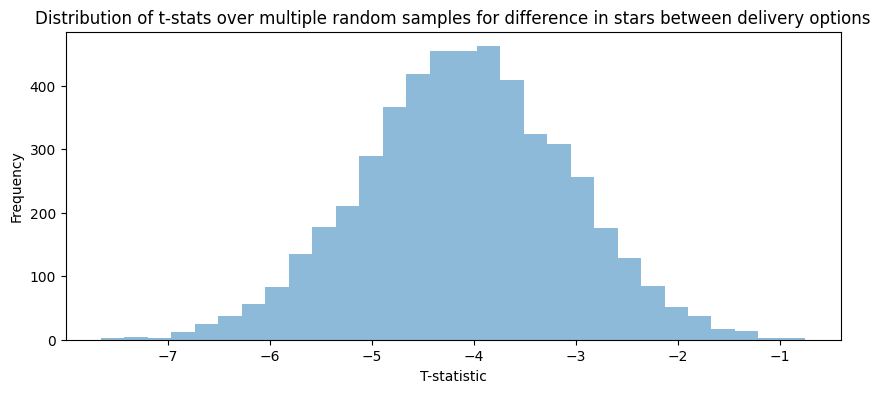

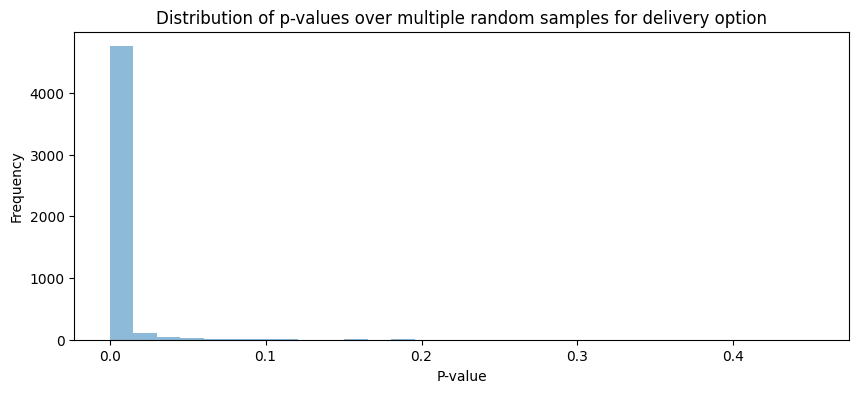

In [11]:
# Evaluating the relationship between rating and delivery option.
yesd = deltake[deltake['RestaurantsDelivery'] == "True"]
nod = deltake[deltake['RestaurantsDelivery'] == "False"]
print(yesd['stars'].mean())
print(nod['stars'].mean())
stats.weightstats.ttest_ind(yesd['stars'], nod['stars'])

n_iterations = 5000
sample_size = 500
t_stats = np.zeros(n_iterations)
p_values = np.zeros(n_iterations)
df = np.zeros(n_iterations)
for i in range(n_iterations):
    sample1 = np.random.choice(yesd['stars'], sample_size, replace=True )
    sample2 = np.random.choice(nod['stars'], sample_size, replace=True)
    t_stat, p_value, df = stats.weightstats.ttest_ind(
    sample1, sample2, usevar='unequal')
    t_stats[i] = t_stat
    p_values[i] = p_value
plt.figure(figsize=(10,4))
plt.hist(t_stats, bins=30, alpha=0.5)
plt.xlabel('T-statistic')
plt.ylabel('Frequency')
plt.title('Distribution of t-stats over multiple random samples for difference in stars between delivery options')
plt.show()

plt.figure(figsize=(10,4))
plt.hist(p_values, bins=30, alpha=0.5)
plt.xlabel('P-value')
plt.ylabel('Frequency')
plt.title('Distribution of p-values over multiple random samples for delivery option')
plt.show()

Our graph of the t-statistic for many samples of our subset is centered around a t-statistic of -4 which suggests that there is a strong difference between the star ratings for the restaurants those with delivery vs those without delivery; the mean rating for the restaurants without a delivery option is higher.
Our graph of p-values for many samples of our subset show that the difference between the two is highly signifcant as the graph is heavily right-skewed and most of the values fall below 0.05.

In [12]:
hasboth = deltake[(deltake['RestaurantsTakeOut'] == "True") & (deltake['RestaurantsDelivery'] == 'True')]
neither = deltake[(deltake['RestaurantsTakeOut'] == "False") & (deltake['RestaurantsDelivery'] == 'False')]
print(hasboth['stars'].mean())
print(neither['stars'].mean())

stats.weightstats.ttest_ind(hasboth['stars'], neither['stars'])

3.4251524217063656
3.600879949717159


(-8.020764875637683, 1.0916341391227403e-15, 27996.0)

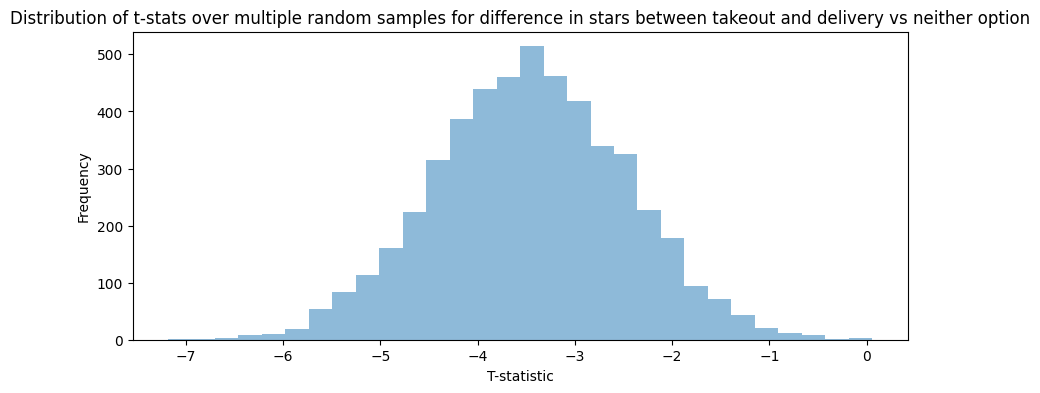

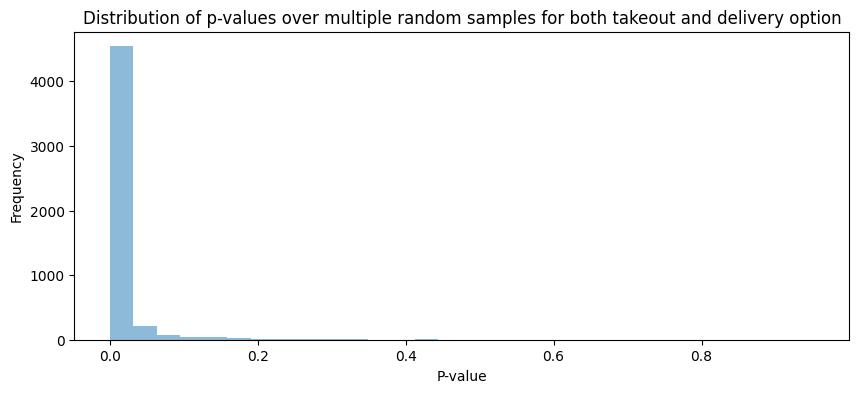

In [13]:
# Evaluating the relationship between rating having both delivery and takeout vs neither option.
n_iterations = 5000
sample_size = 500
t_stats = np.zeros(n_iterations)
p_values = np.zeros(n_iterations)
df = np.zeros(n_iterations)
for i in range(n_iterations):
    sample1 = np.random.choice(hasboth['stars'], sample_size, replace=True )
    sample2 = np.random.choice(neither['stars'], sample_size, replace=True)
    t_stat, p_value, df = stats.weightstats.ttest_ind(
    sample1, sample2, usevar='unequal')
    t_stats[i] = t_stat
    p_values[i] = p_value
plt.figure(figsize=(10,4))
plt.hist(t_stats, bins=30, alpha=0.5)
plt.xlabel('T-statistic')
plt.ylabel('Frequency')
plt.title('Distribution of t-stats over multiple random samples for difference in stars between takeout and delivery vs neither option')
plt.show()

plt.figure(figsize=(10,4))
plt.hist(p_values, bins=30, alpha=0.5)
plt.xlabel('P-value')
plt.ylabel('Frequency')
plt.title('Distribution of p-values over multiple random samples for both takeout and delivery option')
plt.show()

Our graph of the t-statistic for many samples of our subset is centered approximately around a t-statistic of -4 which suggests that there is a strong difference between the star ratings for the restaurants those with both takeout and delivery options compared to restaurants with neither; the mean rating for the restaurants with both a takeout and delivery option is lower.
Our graph of p-values for many samples of our subset show that the difference between the two is highly signifcant as the graph is heavily right-skewed and most of the values fall below 0.05.

### Interpretation of Findings:
It appears that having a takeout option is associated with a higher rating compared to restaurants on Yelp without a takeout option. In contrast, restuarants with a delivery option are associated with a lower rating compared to those without one. Having both a takeout and delivery option is also associated with a lower Yelp rating compared to restaurants without either option. 

Therefore, a restaurant having takeout is an attribute that is associated with a higher Yelp rating, as we suspected, but having a delivery option is associated with a lower Yelp rating which does not match our original hypothesis.

A possible reason for why this is true is that a delivery service may not always be at the control of the restaurant themselves (3rd party apps like DoorDash or UberEats) and therefore quality may be more variable. Another possible reason is that there is a growth of "restaurant" businesses who's main customer base is on delivery apps, tend to have no physical location or operate out of a residence or food truck, and tend to have poor quality food at premium prices because customers pay for the convenience of delivery and often, unusual service hours (businesses offering delivery past 10 pm). For example, if you look on Yelp's "worst restaurants" in Los Angeles, many of the top results are for businesses with customers complaining about the poor quality food they recieved after ordering through DoorDash. These businesses could be skewing the overall rating average for restaurants with delivery to a lower star rating than it would be if we were able to filter out the delivery app-centered businesses and focus our analysis on brick-and-mortar restaurants that happen to offer delivery and takeout options in supplement to their physical dining experience.

***

## Wifi Attribute:
### Hypothesis:
We expect that access to free Wifi is associated with an increase in the rating of the restaurant on Yelp.
### Data Cleaning:

In [14]:
print(restaurant['WiFi'].value_counts(), "\n")

# dropping NAs for Wifi column
wifi = restaurant.dropna(subset = ['WiFi'])
wifi = wifi.loc[wifi['WiFi'] != 'None']
print(wifi['WiFi'].value_counts(), "\n")

# replacing names for clarity
wifi['WiFi'] = wifi['WiFi'].str.replace("u'free'", "free")
wifi['WiFi'] = wifi['WiFi'].str.replace("'free'", "free")
wifi['WiFi'] = wifi['WiFi'].str.replace("u'no'", "no")
wifi['WiFi'] = wifi['WiFi'].str.replace("'no'", "no")
wifi['WiFi'] = wifi['WiFi'].str.replace("u'paid'", "paid")
wifi['WiFi'] = wifi['WiFi'].str.replace("'paid'", "paid")
print(wifi['WiFi'].value_counts())

u'free'    14938
u'no'      11375
'no'        5656
'free'      5483
u'paid'      166
'paid'        95
None          36
Name: WiFi, dtype: int64 

u'free'    14938
u'no'      11375
'no'        5656
'free'      5483
u'paid'      166
'paid'        95
Name: WiFi, dtype: int64 

free    20421
no      17031
paid      261
Name: WiFi, dtype: int64


### Plots:

<Axes: title={'center': 'Distribution of WiFi Availability'}>

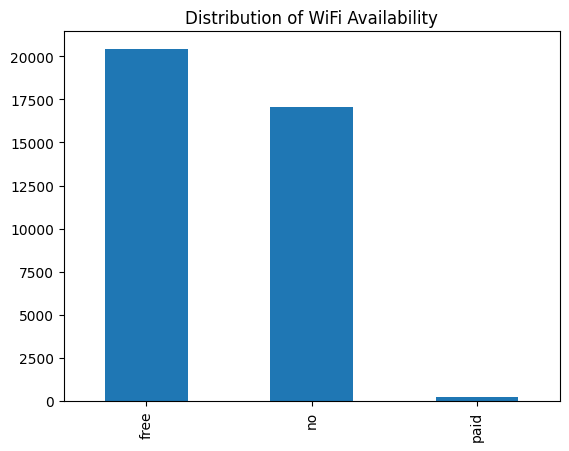

In [15]:
wifi['WiFi'].value_counts().plot(kind = 'bar', title = 'Distribution of WiFi Availability')

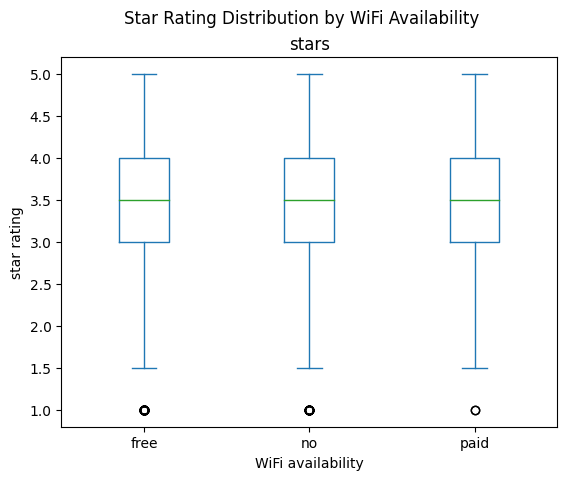

In [16]:
wifi.plot.box(column = ['stars'], 
                 by = 'WiFi', 
                 xlabel = 'WiFi availability', 
                 ylabel = 'star rating',
                 title = 'Star Rating Distribution by WiFi Availability');

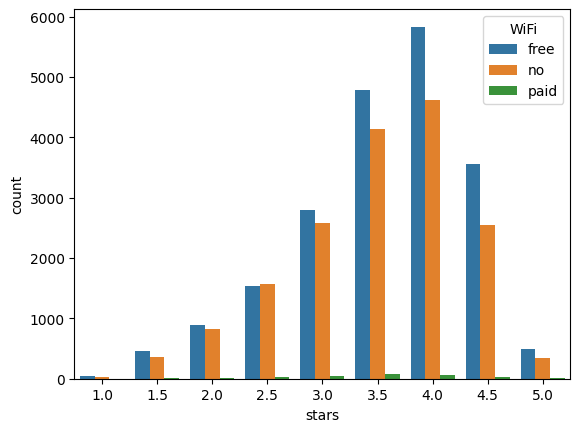

In [17]:
sns.countplot(wifi, x='stars', hue='WiFi');

### Statistical Analysis:

In [18]:
free = wifi[wifi['WiFi']== 'free']
no = wifi[wifi['WiFi']== 'no']
paid = wifi[wifi['WiFi'] == 'paid']
yes = wifi[wifi['WiFi'] != 'no']

print('median of businesses with free Wifi is', free['stars'].median())
print('median of businesses with paid Wifi is', paid['stars'].median())
print('median of businesses with Wifi is', yes['stars'].median())
print('median of businesses with no Wifi is', no['stars'].median())

print('mean of businesses with free Wifi is', free['stars'].mean())
print('mean of businesses with paid Wifi is', paid['stars'].mean())
print('mean of businesses with Wifi is', yes['stars'].mean())
print('mean of businesses with no Wifi is', no['stars'].mean())

median of businesses with free Wifi is 3.5
median of businesses with paid Wifi is 3.5
median of businesses with Wifi is 3.5
median of businesses with no Wifi is 3.5
mean of businesses with free Wifi is 3.593286322902894
mean of businesses with paid Wifi is 3.396551724137931
mean of businesses with Wifi is 3.5908035973310124
mean of businesses with no Wifi is 3.526804063178909


In [19]:
# has wifi vs no wifi
stats.weightstats.ttest_ind(yes['stars'], no['stars'])

(7.9737852618630995, 1.581942172947153e-15, 37711.0)

In [20]:
# free wifi vs paid wifi
stats.weightstats.ttest_ind(free['stars'], paid['stars'])

(4.061896143015436, 4.885517862437894e-05, 20680.0)

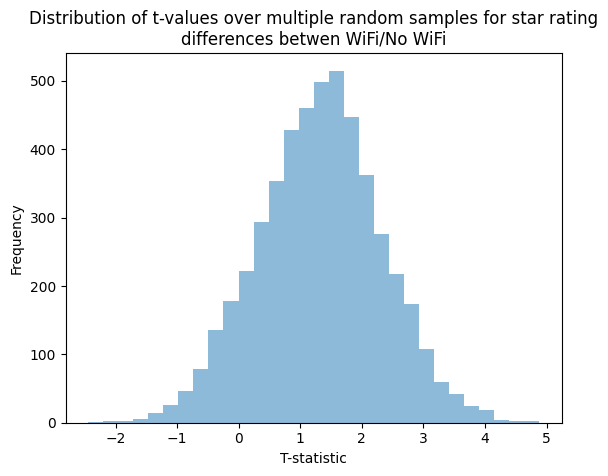

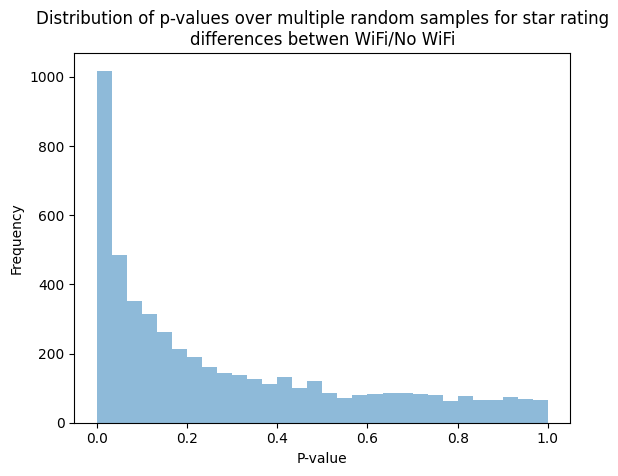

In [21]:
# has wifi vs no wifi
n = 5000
sample_size = 500
t_stats = np.zeros(n)
p_values = np.zeros(n)
df = np.zeros(n)

for i in range(n):
    sample1 = np.random.choice(yes['stars'], sample_size, replace = True)
    sample2 = np.random.choice(no['stars'], sample_size, replace = True)

    t_stat, p_value, df = stats.weightstats.ttest_ind(
        sample1, sample2, usevar='unequal'
    )

    t_stats[i] = t_stat
    p_values[i] = p_value

plt.hist(t_stats, bins=30, alpha=0.5)
plt.xlabel('T-statistic')
plt.ylabel('Frequency')
plt.title('Distribution of t-values over multiple random samples for star rating\ndifferences betwen WiFi/No WiFi')
plt.show()

plt.hist(p_values, bins=30, alpha=0.5)
plt.xlabel('P-value')
plt.ylabel('Frequency')
plt.title('Distribution of p-values over multiple random samples for star rating\ndifferences betwen WiFi/No WiFi')
plt.show()

In [22]:
print(t_stats[t_stats <= -2].size/n)

print(p_values[p_values <= 0.05].size/n)

0.0006
0.254


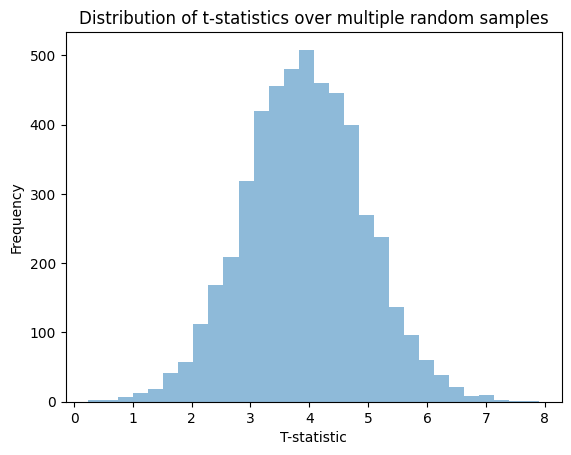

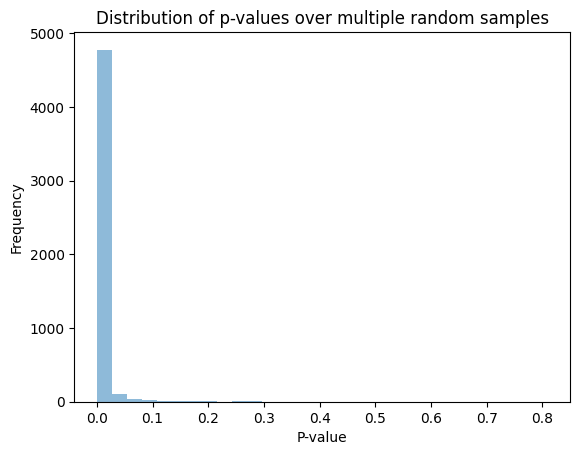

In [23]:
# free vs paid wifi
n2 = 5000
sample_size2 = 500
t_stats2 = np.zeros(n2)
p_values2 = np.zeros(n2)
df2 = np.zeros(n2)

for i in range(n2):
    sample3 = np.random.choice(free['stars'], sample_size, replace = True)
    sample4 = np.random.choice(paid['stars'], sample_size, replace = True)

    t_stat2, p_value2, df2 = stats.weightstats.ttest_ind(
        sample3, sample4, usevar='unequal'
    )

    t_stats2[i] = t_stat2
    p_values2[i] = p_value2

plt.hist(t_stats2, bins=30, alpha=0.5)
plt.xlabel('T-statistic')
plt.ylabel('Frequency')
plt.title('Distribution of t-statistics over multiple random samples')
plt.show()

plt.hist(p_values2, bins=30, alpha=0.5)
plt.xlabel('P-value')
plt.ylabel('Frequency')
plt.title('Distribution of p-values over multiple random samples')
plt.show()

In [24]:
print(t_stats2[t_stats2 <= -2].size/n2)
print(p_values2[p_values2 <= 0.05].size/n2)

0.0
0.9742


### Interpretation of Findings:
When comparing the star ratings of having WiFi and no WiFi, the null hypothesis would be that there is no difference between the mean star rating of restaurants that provides WiFi and when it does not. The t-statistic distribution in this case is centered above 0, showing that there seems to be a significant correlation between having WiFi and having a higher star rating. The percentage of t-statistics that are lower than -2 are about 0%, which suggests that it is extremely unlikely that the mean star ratings for restaurants without WiFi would be higher than that of restaurants with WiFi. The p-value generated at 1.58e-15 is also less than 0.05. Around 26% of the p-values generated are less than 0.05. Thus, we can reject the null hypothesis.

When looking closer at restaurants who have WiFi, we examined restaurants who provide free and paid WiFi. The null hypothesis would be that there is no difference between the mean star ratings of restaurants that have free WiFi and those that have paid WiFi. The t-statistic distribution is centered around 4 and the percentage of t-statistics that is less than -2 is around 0%. This suggests that there is a correlation between restaurants that provide free WiFi and higher ratings. The probability of the mean star rating for restaurants that require paid WiFi being higher than those that provide free WiFi is about 0%. Moreover, the p-value is around 4.89e-05 and around 97% of the time, the p-value is less than 0.05. Thus, we reject the null hypothesis.

In conclusion, we find that 
1. There is a correlation between restaurants with WiFi and higher star ratings
2. There is a correlation between restaurants that provide free WiFi and higher star ratings

***

## Alcohol Attribute:
### Hypothesis:
Restaurants selling alcohol will be associated with an increase the restaurants’ rating on Yelp compared to restaurants without alcohol. In combination with the GoodForKids variable, restaurants selling alcohol and that are a family friendly establishment would instead show a decrease in rating.
### Data Cleaning for the Alcohol Attribute:

In [25]:
print("Before additional cleaning:\n", restaurant['Alcohol'].value_counts(), "\n")

restaurant['Alcohol'] = restaurant['Alcohol'].str.replace("u'", "").str.replace("'", "")
restaurant['Alcohol'] = restaurant['Alcohol'].str.replace("none", "no_alcohol") # for clarity
avg_ratings = restaurant.groupby('Alcohol')['stars'].mean().reset_index()
avg_ratings = avg_ratings[avg_ratings['Alcohol'] != 'None'] # exclude None (i.e. missing data)
alc = restaurant[restaurant['Alcohol'] != 'None'].dropna(subset=['Alcohol'])

print("After Cleaning:\n", alc['Alcohol'].value_counts(), "\n")
print("Average Star Rating by Alcohol Offering:\n", avg_ratings)

Before additional cleaning:
 u'none'             15641
u'full_bar'         11440
'none'               4662
u'beer_and_wine'     4589
'full_bar'           2455
'beer_and_wine'      1159
None                   34
Name: Alcohol, dtype: int64 

After Cleaning:
 no_alcohol       20303
full_bar         13895
beer_and_wine     5748
Name: Alcohol, dtype: int64 

Average Star Rating by Alcohol Offering:
          Alcohol     stars
1  beer_and_wine  3.791145
2       full_bar  3.533069
3     no_alcohol  3.479264


/var/folders/w_/840l9l9n3yb3386159xg4hmm0000gn/T/ipykernel_29945/3895717035.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restaurant['Alcohol'] = restaurant['Alcohol'].str.replace("u'", "").str.replace("'", "")
/var/folders/w_/840l9l9n3yb3386159xg4hmm0000gn/T/ipykernel_29945/3895717035.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restaurant['Alcohol'] = restaurant['Alcohol'].str.replace("none", "no_alcohol") # for clarity


### Plots:

<Axes: title={'center': 'Average Rating by Alcohol Category'}, xlabel='Alcohol', ylabel='Average Rating'>

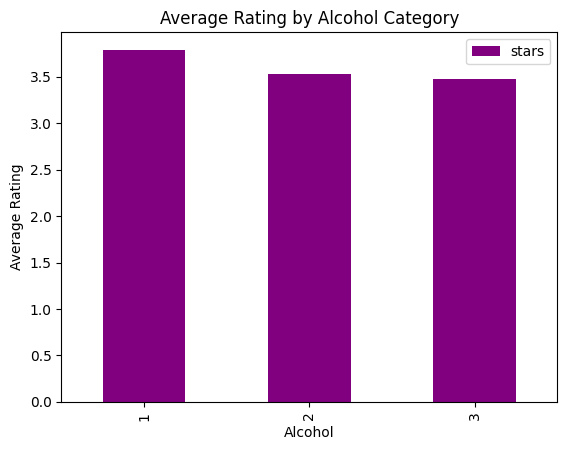

In [26]:
avg_ratings.plot(kind = 'bar', color = 'purple', 
                 xlabel = 'Alcohol', ylabel = 'Average Rating',
                 title = 'Average Rating by Alcohol Category')

stars    Axes(0.125,0.11;0.775x0.77)
dtype: object

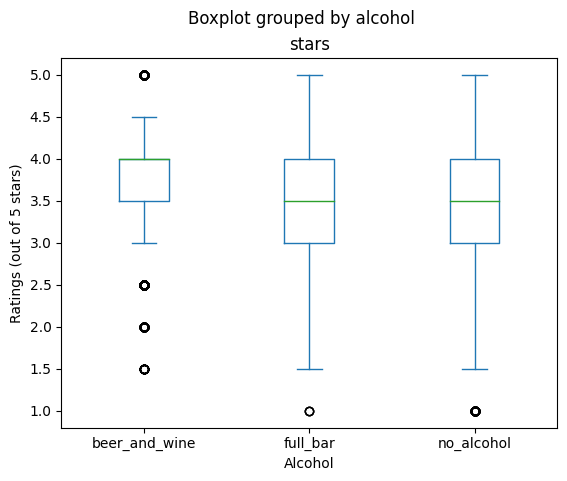

In [27]:
alc.plot.box(column = ['stars'], by = 'Alcohol',
                        xlabel = 'Alcohol', ylabel = 'Ratings (out of 5 stars)',
                        title = "Boxplot grouped by alcohol")

### Statistical Analysis:

In [28]:
# Separate the ratings based on the 'Alcohol' category
alcohol_ratings = alc[alc['Alcohol'] != 'no_alcohol']['stars']
no_alcohol_ratings = alc[alc['Alcohol'] == 'no_alcohol']['stars']

# Perform independent samples t-test
t_statistic, p_value = st.ttest_ind(alcohol_ratings, no_alcohol_ratings, equal_var=False)

# Print the results
print("T-Statistic:", t_statistic)
print("P-Value:", p_value)

T-Statistic: 16.98496559927429
P-Value: 1.855905087138961e-64


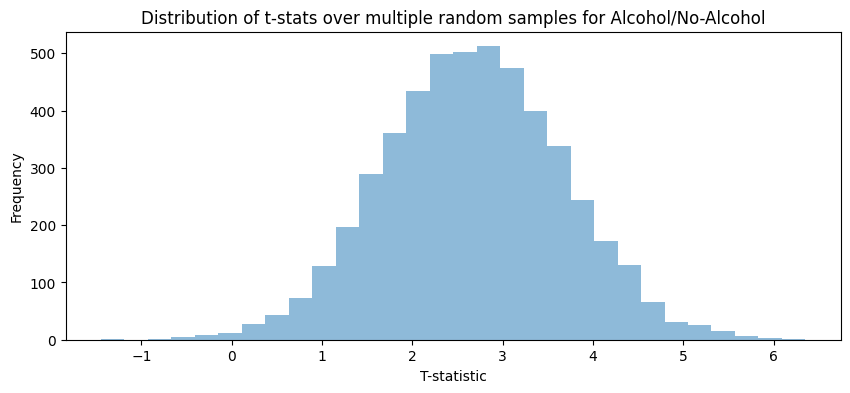

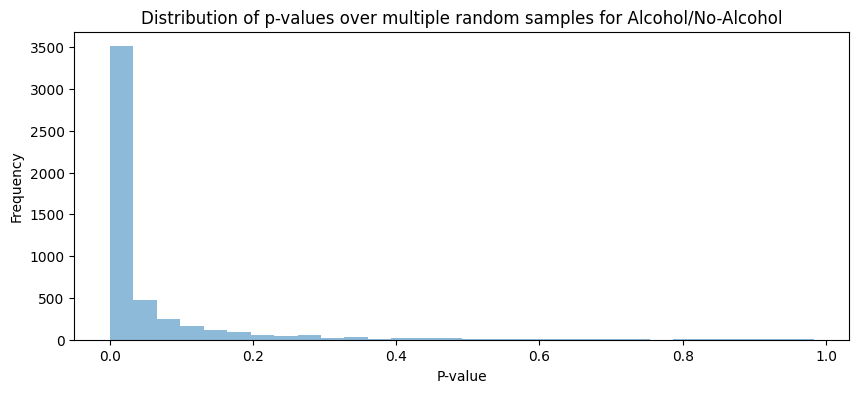

In [29]:
stats.weightstats.ttest_ind(alcohol_ratings, no_alcohol_ratings)

n_iterations = 5000
sample_size = 500
t_stats = np.zeros(n_iterations)
p_values = np.zeros(n_iterations)
df = np.zeros(n_iterations)
for i in range(n_iterations):
    sample1 = np.random.choice(alcohol_ratings, sample_size, replace=True )
    sample2 = np.random.choice(no_alcohol_ratings, sample_size, replace=True)
    t_stat, p_value, df = stats.weightstats.ttest_ind(
    sample1, sample2, usevar='unequal')
    t_stats[i] = t_stat
    p_values[i] = p_value
plt.figure(figsize=(10,4))
plt.hist(t_stats, bins=30, alpha=0.5)
plt.xlabel('T-statistic')
plt.ylabel('Frequency')
plt.title('Distribution of t-stats over multiple random samples for Alcohol/No-Alcohol')
plt.show()

plt.figure(figsize=(10,4))
plt.hist(p_values, bins=30, alpha=0.5)
plt.xlabel('P-value')
plt.ylabel('Frequency')
plt.title('Distribution of p-values over multiple random samples for Alcohol/No-Alcohol')
plt.show()

### Multivariate Analysis with the "Good for Kids" Variable:

In [30]:
# Find the common indices for 'no_alcohol' and 'True' ratings
common_indices = alc.loc[(alc['Alcohol'] == 'no_alcohol') & (alc['GoodForKids'] == 'True')].index

# Select the ratings based on the common indices
no_alcohol_ratings = alc.loc[common_indices, 'stars']
good_for_kids_ratings = alc.loc[common_indices, 'stars']

# Calculate the correlation coefficient and p-value
correlation_coefficient, p_value = st.pearsonr(no_alcohol_ratings, good_for_kids_ratings)

# Print the correlation coefficient
print(correlation_coefficient)

0.9999999999999847


In [31]:
print(alc['GoodForKids'].value_counts(), "\n")
# group by 'Alcohol' and 'GoodForKids' and calculate the average star rating
alckidsg = alc.groupby(['Alcohol', 'GoodForKids'])['stars'].mean().reset_index()

# exclude None (i.e. missing data)
alckidsg = alckidsg[(alckidsg['Alcohol'] != 'None') & (alckidsg['GoodForKids'] != 'None')].dropna(subset=['GoodForKids'])

print(alckidsg)

True     30424
False     5488
None         6
Name: GoodForKids, dtype: int64 

         Alcohol GoodForKids     stars
0  beer_and_wine       False  3.820580
1  beer_and_wine        True  3.747130
2       full_bar       False  3.578954
4       full_bar        True  3.453186
5     no_alcohol       False  3.267117
7     no_alcohol        True  3.436158


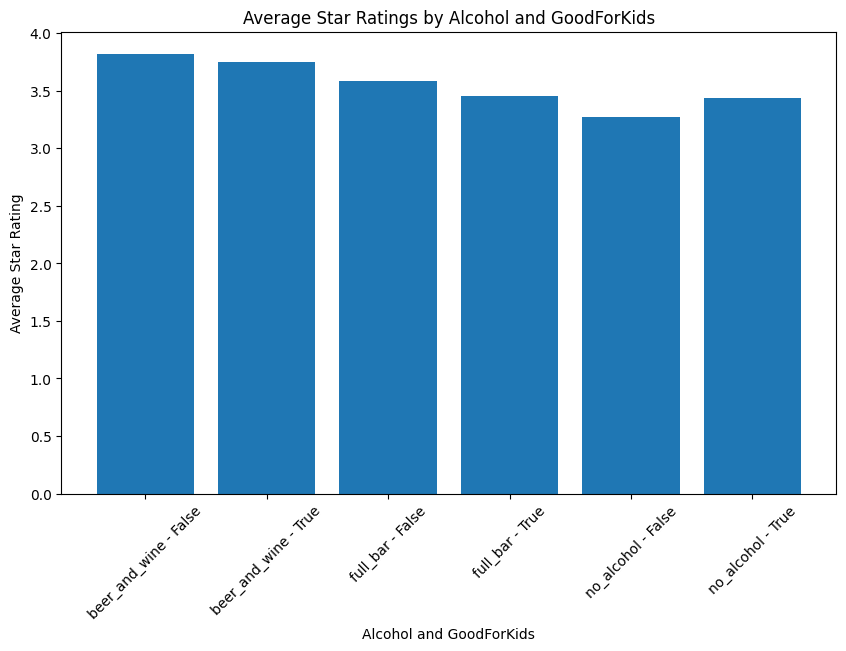

In [32]:
# Bar plot of average star ratings for each group:
plt.figure(figsize=(10, 6))
plt.bar(range(len(alckidsg)), alckidsg['stars'])
plt.xticks(range(len(alckidsg)), alckidsg['Alcohol'] + ' - ' + alckidsg['GoodForKids'], rotation=45)
plt.title("Average Star Ratings by Alcohol and GoodForKids")
plt.xlabel("Alcohol and GoodForKids")
plt.ylabel("Average Star Rating")
plt.show()

stars    Axes(0.125,0.11;0.775x0.77)
dtype: object

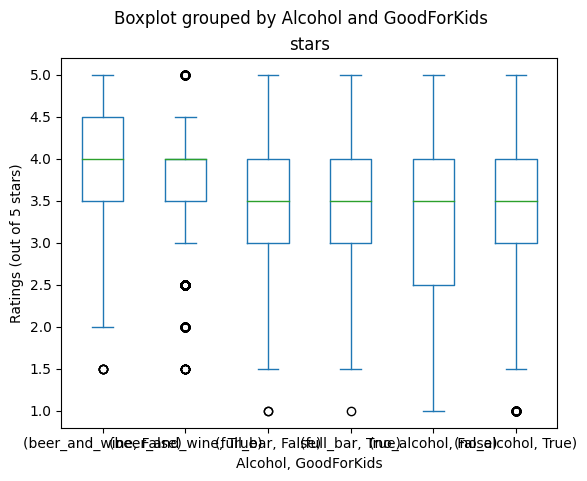

In [33]:
alckids = alc[(alc['Alcohol'] != 'None') & (alc['GoodForKids'] != 'None')].dropna(subset=['GoodForKids'])

alckids.plot.box(column='stars', by=['Alcohol', 'GoodForKids'],
                       xlabel='Alcohol, GoodForKids', ylabel='Ratings (out of 5 stars)',
                       title="Boxplot grouped by Alcohol and GoodForKids")
                            

/var/folders/w_/840l9l9n3yb3386159xg4hmm0000gn/T/ipykernel_29945/2355670314.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  plt.imshow(alckidsg.pivot('Alcohol', 'GoodForKids', 'stars'), cmap='YlGnBu')


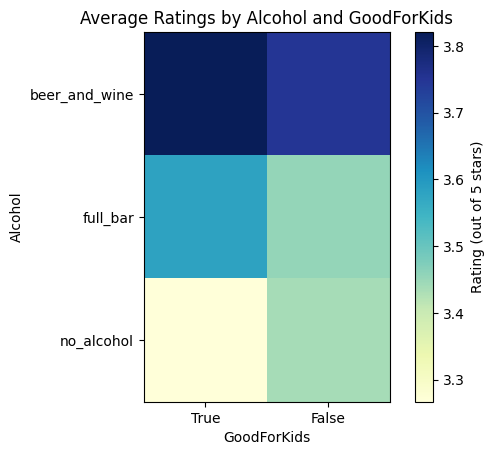

In [34]:
# Color contour plot:
plt.imshow(alckidsg.pivot('Alcohol', 'GoodForKids', 'stars'), cmap='YlGnBu')
plt.colorbar(label='Rating (out of 5 stars)')
plt.title('Average Ratings by Alcohol and GoodForKids')
plt.xlabel('GoodForKids')
plt.ylabel('Alcohol')
plt.xticks(range(len(alckids['GoodForKids'].unique())), alckids['GoodForKids'].unique())
unique_alcohol = alckids['Alcohol'].unique()
reversed_range = range(len(unique_alcohol) - 1, -1, -1)
plt.yticks(reversed_range, unique_alcohol)
plt.show()

### Interpretation of Findings:
Based on the resulting t-statistic and corresponding p-value, it appears that there is a significant impact of alcohol on ratings. The t-statistic measures the difference between the means of the two groups (i.e. alcohol and no alcohol), relative to the variability within each group. The t-statistic being far from 0 and positive (approximately 16.985) suggests that the means of the two groups are highly dissimilar and therefore significant. The approximately normal t-statistic distribution centered around 2.8 reflects this as it indicates that, on average, the difference in ratings between restaurants with alcohol and those without alcohol is positive and statistically significant. 

Also, the p-value represents the probability of observing the given t-statistic (or a more extreme value) under the assumption that there is no true difference between the groups. In this case, the p-value is remarkably less than a typical significance level of 0.05. From this, we can reject the null hypothesis that there is no significant difference in ratings between restaurants with and without alcohol. The distribution of p-values validates this conclusion as the majority of p-values in it are 0, meaning that over multiple random samples, the observed t-statistic consistently falls within a range that is highly unlikely to occur if there was no true difference in ratings between the two groups. In conclusion, our statistical analysis provides strong evidence to support our hypothesis that selling alcohol at restaurants is associated with higher ratings on Yelp than having no alcohol. 

In regards to our multivariate analysis, the resulting correlation coefficient of almost 1 indicates an extremely strong positive correlation between the ratings restaurants with no alcohol and ratings fo restaurants that are good for kids. This means that as the 'no_alcohol' ratings increase, the 'True' ratings for 'GoodForKids' also tend to increase (and vice versa) with the two variables moving almost perfectly in tandem with each other. This suggests that there may be a common underlying factor or preference among Yelp reviewers for restaurants that are both alcohol-free and suitable for children, meaning that factors related to being family-friendly and catering to the needs of children may play a more significant role in influencing the ratings of restaurants than alcohol alone. 

Both the barplot and color contour plot of average star ratings categorized by the attributes of alcohol and GoodForKids reveal a pattern that contradicts our expectations. Among the different categories, the highest average rating is observed for the combination of beer_and_wine with "False," indicating that restaurants serving beer and wine and not being good for kids tend to receive the highest ratings. Meanwhile, the average ratings for the combination of no_alcohol with "True" (representing restaurants without alcohol and considered good for kids) appear to be relatively lower. This indicates that family-friendly restaurants may receive lower ratings compared to establishments that offer alcohol and are not marketed as good for kids. These findings ultimately suggest that the presence of alcohol, specifically in the form of beer and wine, is positively associated with higher ratings on Yelp, regardless of whether the restaurant is family-friendly; this implies customers perceive selling alcohol as a valuable attribute when rating restaurants on Yelp. 

However, it is important to note that our conclusions are based on the observed average ratings and the specific attributes of alcohol and GoodForKids. Other factors and individual preferences may also contribute to the overall rating of a restaurant. Therefore, further analysis and consideration of additional variables are necessary to gain a comprehensive understanding of the relationship between these attributes and star ratings.

***

## Credit Card Variable:
### Hypothesis:
Restaurants that don’t accept credit cards will be associated with a decrease in the rating on Yelp compared to restaurants that take them.

### Data Cleaning:

In [35]:
print(restaurant['BusinessAcceptsCreditCards'].value_counts(), "\n")

ccavg_ratings = restaurant.groupby('BusinessAcceptsCreditCards')['stars'].mean().reset_index()
ccavg_ratings = ccavg_ratings[ccavg_ratings['BusinessAcceptsCreditCards'] != 'None'] # exclude None (i.e. missing data)
print(ccavg_ratings)

True     44141
False     1406
None        26
Name: BusinessAcceptsCreditCards, dtype: int64 

  BusinessAcceptsCreditCards     stars
0                      False  3.894737
2                       True  3.496341


### Plots:

<Axes: ylabel='BusinessAcceptsCreditCards'>

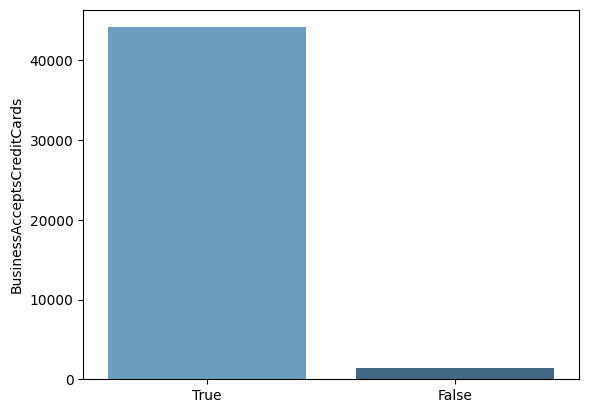

In [36]:
cc = restaurant[restaurant['BusinessAcceptsCreditCards'] != 'None'].dropna(subset=['BusinessAcceptsCreditCards'])
sns.barplot(x = cc['BusinessAcceptsCreditCards'].value_counts().index, 
           y = cc['BusinessAcceptsCreditCards'].value_counts(), 
           palette = 'Blues_d')

<Axes: title={'center': 'Average Rating by Credit Card Acceptance'}, xlabel='Business Accepts Credit Cards', ylabel='Average Rating'>

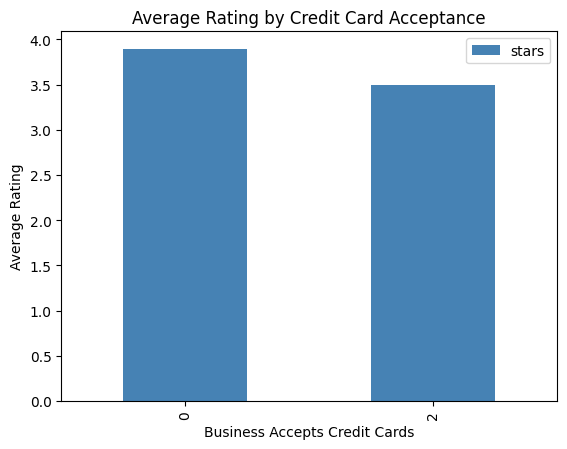

In [37]:
ccavg_ratings.plot(kind = 'bar', color = '#4682B4',
                 xlabel = 'Business Accepts Credit Cards', ylabel = 'Average Rating',
                 title = 'Average Rating by Credit Card Acceptance')

stars    Axes(0.125,0.11;0.775x0.77)
dtype: object

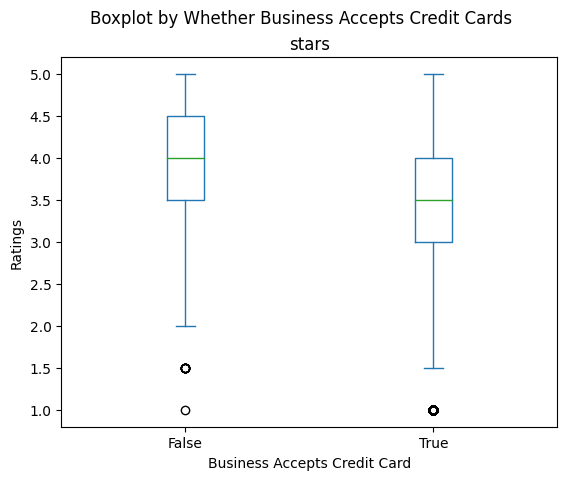

In [38]:
cc.plot.box(column = ['stars'], by = 'BusinessAcceptsCreditCards',
                        xlabel = 'Business Accepts Credit Card', ylabel = 'Ratings',
                        title = "Boxplot by Whether Business Accepts Credit Cards")

In [39]:
counts = cc.groupby(['BusinessAcceptsCreditCards', 'stars']).size()
totals = cc.groupby(['BusinessAcceptsCreditCards', 'stars']).size().groupby(level = 0).sum()
group_ratios = (counts/totals)* 100
group_ratios = group_ratios.reset_index()
group_ratios

,BusinessAcceptsCreditCards,stars,0
0,False,1.0,0.071124
1,False,1.5,0.640114
2,False,2.0,1.849218
3,False,2.5,3.840683
4,False,3.0,9.957326
5,False,3.5,18.136558
6,False,4.0,31.863442
7,False,4.5,27.738265
8,False,5.0,5.903272
9,True,1.0,0.362475


Text(0, 0.5, 'Ratio')

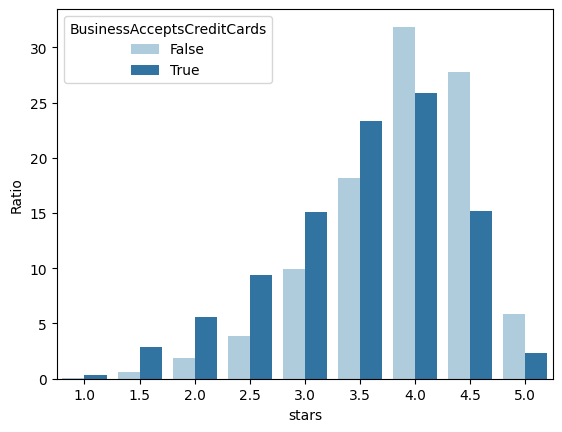

In [40]:
custom_palette = ["#1E90FF", "#6495ED"]
sns.barplot(x = 'stars', y = 0, hue = 'BusinessAcceptsCreditCards', 
           data = group_ratios, palette = "Paired")
plt.ylabel('Ratio')

### Statistical Analysis:

In [41]:
df_true = cc[cc['BusinessAcceptsCreditCards'] != 'True']['stars'] 
df_false = cc[cc['BusinessAcceptsCreditCards'] != 'False']['stars']
t_statistic, p_value = st.ttest_ind(df_true, df_false, equal_var = False) 
print("T-stat:", t_statistic)
print("p-value:", p_value)

T-stat: 21.33037995144456
p-value: 1.2705140494601788e-88


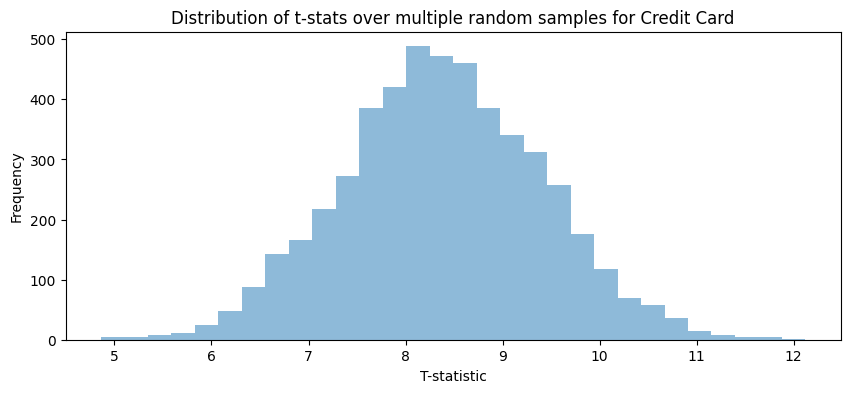

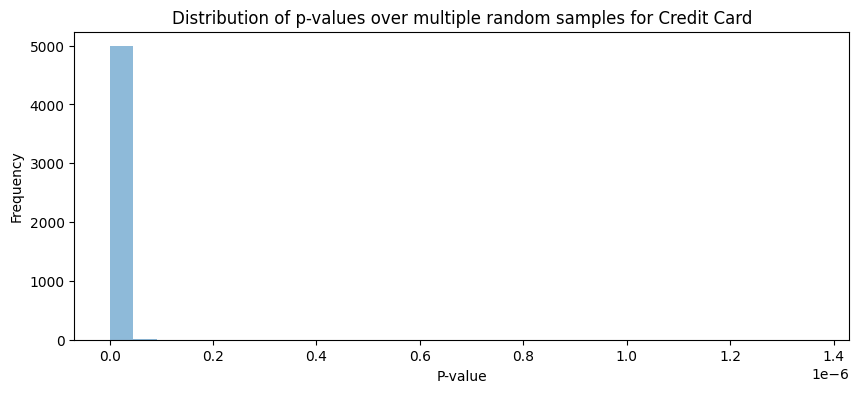

In [42]:
stats.weightstats.ttest_ind(df_true, df_false) 
n_iterations = 5000
sample_size = 500
t_stats = np.zeros(n_iterations)
p_values = np.zeros(n_iterations) 
df = np.zeros(n_iterations)
for i in range(n_iterations):
    sample1 = np.random.choice(df_true, sample_size, replace=True ) 
    sample2 = np.random.choice(df_false, sample_size, replace=True) 
    t_stat, p_value, df = stats.weightstats.ttest_ind(sample1, sample2, usevar='unequal')
    t_stats[i] = t_stat
    p_values[i] = p_value
plt.figure(figsize=(10,4))
plt.hist(t_stats, bins=30, alpha=0.5)
plt.xlabel('T-statistic')
plt.ylabel('Frequency')
plt.title('Distribution of t-stats over multiple random samples for Credit Card') 
plt.show()

plt.figure(figsize=(10,4))
plt.hist(p_values, bins=30, alpha=0.5)
plt.xlabel('P-value')
plt.ylabel('Frequency')
plt.title('Distribution of p-values over multiple random samples for Credit Card') 
plt.show()

### Interpretation of Findings:

Looking soley at the count of the credit cards, we can see that there is significantly more restaurants that accept credit cards. When comparing the average star rating between restaurants that accept credit card and that does not accept credit card, we can observe that the restaurant that does not accept credit card actually have a higher rating by about 0.04. Furthermore, businesses that does not accept credit cards have more number of 4.0 and 5.0 ratings.According to the p-value of 1.27e-88, we reject the null hypothesis at the significance level of 0.05. We conclude that there is a significant association between the acceptance of credit cards and star rating of restaurants on Yelp. 

***

## Price Range and Attire Attributes:
### Hypothesis:
At higher price ranges 3 and 4 ($$$ and $$$$), having formal restaurant attire will be associated with an increase in the Yelp rating.
### Data Cleaning:

casual    38089
dressy      796
formal       70
None         37
Name: RestaurantsAttire, dtype: int64


/var/folders/w_/840l9l9n3yb3386159xg4hmm0000gn/T/ipykernel_29945/2807160831.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restaurant['RestaurantsAttire'] = restaurant['RestaurantsAttire'].str.replace("u'", "").str.replace("'", "")


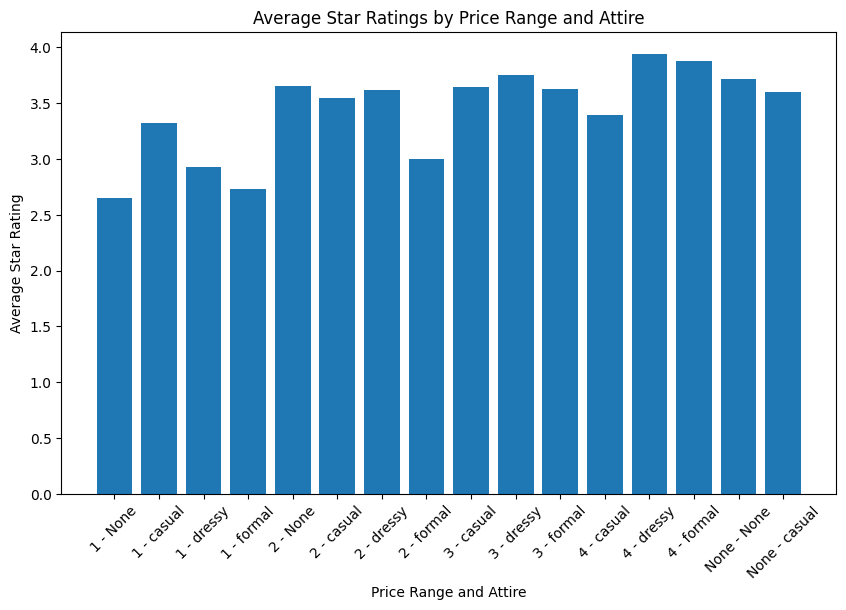

In [43]:
# Group by 'price_range' and 'attire' and calculate the average star rating
restaurant['RestaurantsAttire'] = restaurant['RestaurantsAttire'].str.replace("u'", "").str.replace("'", "")
grouped_pa= restaurant.groupby(['RestaurantsPriceRange2', 'RestaurantsAttire'])['stars'].mean().reset_index()
print(restaurant['RestaurantsAttire'].value_counts())


# Create a bar plot of average star ratings for each group
plt.figure(figsize=(10, 6))
plt.bar(range(len(grouped_pa)), grouped_pa['stars'])
plt.xticks(range(len(grouped_pa)), grouped_pa['RestaurantsPriceRange2'] + ' - ' + grouped_pa['RestaurantsAttire'], rotation=45)
plt.title("Average Star Ratings by Price Range and Attire")
plt.xlabel("Price Range and Attire")
plt.ylabel("Average Star Rating")
plt.show()

### Statistical Analysis:

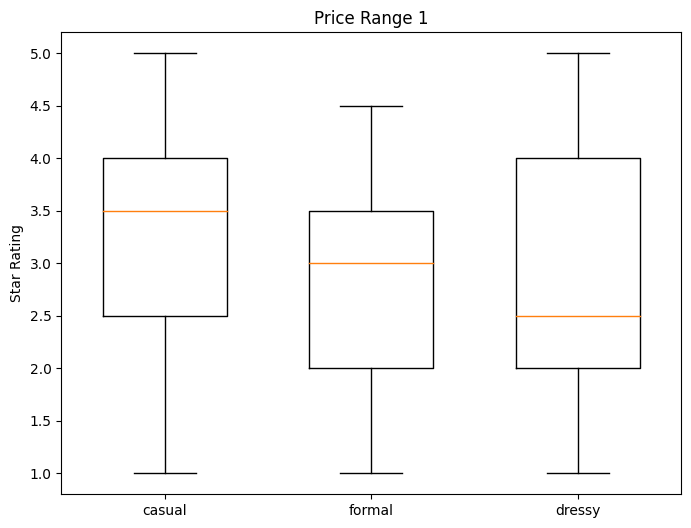

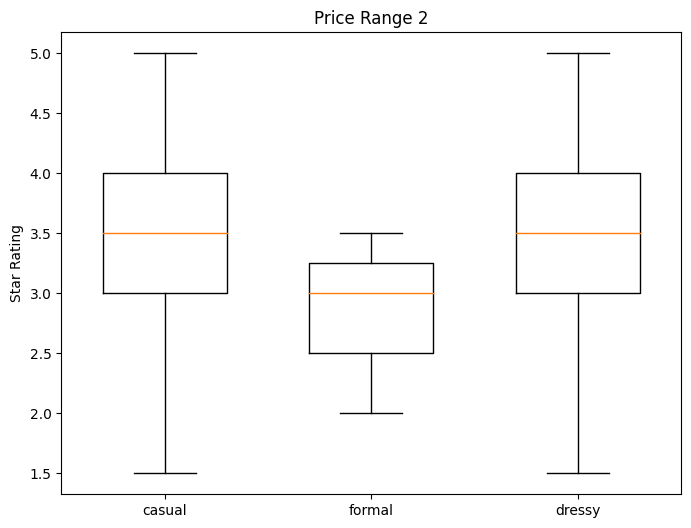

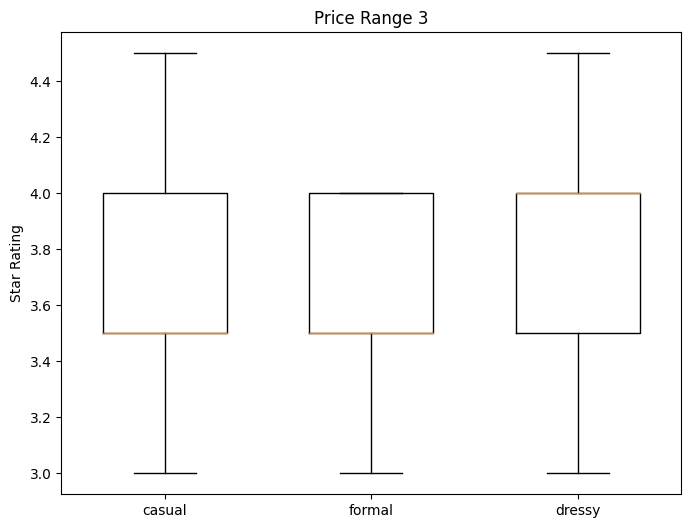

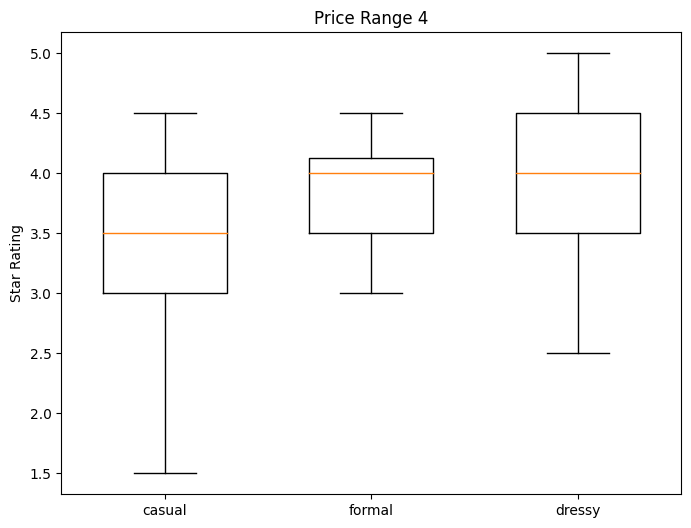

In [44]:
# Filter the data for price ranges 1, 2, 3, and 4
price_range_1_data = restaurant[restaurant['RestaurantsPriceRange2'] == '1']
price_range_2_data = restaurant[restaurant['RestaurantsPriceRange2'] == '2']
price_range_3_data = restaurant[restaurant['RestaurantsPriceRange2'] == '3']
price_range_4_data = restaurant[restaurant['RestaurantsPriceRange2'] == '4']

# Attire categories to plot
attire_categories = ['casual', 'formal', 'dressy']

# Create separate box plots for each price range
for i, price_range_data in enumerate([price_range_1_data, price_range_2_data, price_range_3_data, price_range_4_data]):
    # Create a separate figure for each price range
    plt.figure(figsize=(8, 6))
    
    # Create separate box plots for each attire category within the price range
    for attire_category in attire_categories:
        data = price_range_data[price_range_data['RestaurantsAttire'] == attire_category]['stars']
        plt.boxplot(data, positions=[attire_categories.index(attire_category) + 1], widths=0.6, showfliers=False)
    
    # Set x-axis labels and title for the plot
    plt.xticks(range(1, len(attire_categories) + 1), attire_categories)
    plt.title('Price Range ' + str(i + 1))
    
    # Set y-axis label
    plt.ylabel('Star Rating')
    
    # Display the plot
    plt.show()

### Interpretation of Findings:
At the lowest price range represented by the value 1 in the dataset, restaurants stating casual attire have a higher rating on average than restaurants in the same price range stating dressy or formal attire. In the middle two price ranges, there appears to be less of an obvious relation between star rating and level of attire. However at the highest price range, it appears that restaurants that state having formal or dressy attire have a higher rating on average. 

***

## In Conclusion:
### Findings in Relation to our Hypotheses:
We found that the attributes we focused on; takeout, delivery, wifi, alcohol options, credit card as a form of payment option, price range per person and attire, are all associated with having an effect on a business' Yelp rating. 

Having a takeout option, having Wifi, alcohol options, credit card option, price range and attire are associated with an increase in Yelp rating. 

Having a delivery option is associated with a decrease in Yelp rating.
### Implications:
Restaurants could possibly increase their Yelp rating and overall customer satisfaction by adding a takeout option to their business. It might harm a restaurants sales and rating to get rid of a delivery option if they already have one so we would not recommend doing so, but they could acknowledge that businesses with delivery tend to have lower ratings and ensure that their own delivery service quality is up to par and provide incentive for customers to visit their location and dine-in or get takeout rather than use a 3rd party app like DoorDash for delivery.

We have found that businesses with Wifi and more specifically, free Wifi is correlated with having a higher rating. This suggests that businesses should include free Wifi access for their customers to increase their customer satisfaction and ratings.

We found strong evidence to validate our hypothesis that selling alcohol at restaurants is associated with higher ratings on Yelp than having no alcohol. However, our findings from multivariate analysis between the sale of alcohol, being good for kids, and star ratings contradict our expectations by suggesting that selling alcohol, particularly beer and wine, is positively associated with higher ratings on Yelp, regardless of whether or not the restaurant is family-friendly. Taking this into account, restaurants could consider adding alcohol options to their menu.

Restaurants that doesn’t accept credit cards should have the option for different payment methods due to the increasing trend of allowing the usage of credit cards but it will not actually deter the overall customer satisfaction of the restaurant. 

For restaurants in the lowest price range, stating casual attire is associated with a higher average star rating. This implies that customers in this price range may prefer a more relaxed and casual dining experience. Businesses in this category can consider adopting a casual dress code to align with customer preferences and enhance the overall dining experience. Attire can also contribute to the overall perception and atmosphere of a restaurant. Businesses can leverage their chosen attire style as part of their branding strategy to create a unique and consistent customer experience. Whether it's casual, formal, or dressy attire, it should align with the target market and desired positioning of the restaurant.